## 1. Carga de datos y limpieza inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from leer_red import leer_red_df, leer_subred_df

sns.set()

In [2]:
#data = pd.read_csv(data_dir + 'GwasCat_associations.r2020-05-03.parsed.csv.gz')
# data = pd.read_table(data_dir + 'gwas_cat.filtrado.tsv.gz')
# data = leer_red_df()
data = leer_subred_df()

#### PASAR A NOTEBOOK DE EDA ####

In [ ]:
n_categoria_fenotipo = data[['alelo_riesgo','categoria_fenotipo']].groupby(by = 'alelo_riesgo').agg(pd.Series.nunique)

In [ ]:
n_categoria_fenotipo.nlargest(50, columns = 'categoria_fenotipo')[:5].index

In [ ]:
mask = data.alelo_riesgo.isin(n_categoria_fenotipo.nlargest(50, columns = 'categoria_fenotipo')[1:3].index)
data[mask].sort_values(by = ['alelo_riesgo', 'categoria_fenotipo'])

In [ ]:
aux = pd.DataFrame(aux).drop(columns = 'categoria_fenotipo').reset_index()

In [ ]:
data.shape

Seleccionamos aquellas instancias que tienen en la columna `alelo_riesgo` un SNP.

In [3]:
mask_snps = data.alelo_riesgo.str.match("^rs[0-9]+-[ATCG\?]$")
data = data[mask_snps]
data.shape

(21990, 4)

Miramos y descartamos valores faltantes

In [4]:
data.isna().sum()

gen_mapeado_elegido    9471
alelo_riesgo              0
fenotipo                  0
categoria_fenotipo        0
dtype: int64

No nos interesan aquellas instancias que tienen valore faltantes en la columna `categoria_fenotipo`

In [5]:
data.dropna(subset = ['categoria_fenotipo'], inplace = True)
data.shape

(21990, 4)

In [6]:
data.isna().sum()

gen_mapeado_elegido    9471
alelo_riesgo              0
fenotipo                  0
categoria_fenotipo        0
dtype: int64

**Opcional 1**: sacamos aquellos alelos que aparezcan una sola vez. Sirve más que nada para achicar la base de datos.

In [ ]:
if False:
    umbral = 1
    mask_alelos_poca_frecuencia = data.alelo_riesgo.value_counts() <=1
    mask_alelos_poca_frecuencia.head()

    alelos_poca_frecuencia = list(mask_alelos_poca_frecuencia.index[mask_alelos_poca_frecuencia.values])
    print(len(alelos_poca_frecuencia))

    mask_descartables = data.alelo_riesgo.isin(alelos_poca_frecuencia)
    mask_descartables

    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

**Opcional 2:** Sacamos aquellos fenotipos que aparecen una sola vez:

In [ ]:
if False:
    umbral = 1
    mask_fenotipos_poca_frecuencia = data.fenotipo.value_counts() <=1
    mask_fenotipos_poca_frecuencia.head()
    fenotipos_poca_frecuencia = list(mask_fenotipos_poca_frecuencia.index[mask_fenotipos_poca_frecuencia.values])
    print(len(fenotipos_poca_frecuencia))
    mask_descartables = data.fenotipo.isin(fenotipos_poca_frecuencia)
    # mask_descartables
    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

## 3. Train test split y componente gigante

Hay más de una forma de hacer una separación de datos de entrenamiento y testeo. Vamos a tomar algunos elementos de la matriz de incidencia al azar y sacarlos, asegurándonos que:
1. La red resultante tenga una única componente gigante.
2. Cada fenotipo y alelo separado en el conjunto de test siga apareciendo en el conjunto de train.

Primero chequeamos que la red así como está tenga una única componente gigante. Sino, seleccionamos la componente gigante.

In [7]:
import networkx as nx

In [8]:
red = nx.Graph()
red.add_edges_from(data[['alelo_riesgo', 'fenotipo']].values)
print(f'Tiene una unica componente gigante: {nx.is_connected(red)}')

Tiene una unica componente gigante: False


Veamos cómo son las componentes:

In [9]:
# Devuelve conjuntos de nodos, agrupados por componente
Componentes = nx.connected_components(red)
print(f'En total hay {len(list(Componentes))} componentes en la red')

En total hay 534 componentes en la red


In [10]:
# Armo una lista de componentes, ordenadas por tamaño
lista_redes_componentes=[red.subgraph(componente) for componente in sorted(nx.connected_components(red), key=len, reverse=True)]
n_elementos_redes_componentes=[componente.number_of_edges() for componente in lista_redes_componentes]
print(n_elementos_redes_componentes[:20])
componente_gigante = lista_redes_componentes[0]
nodos_componente_gigante = list(componente_gigante.nodes())

[16903, 205, 143, 137, 150, 96, 81, 74, 70, 68, 64, 62, 64, 57, 50, 50, 47, 45, 45, 44]


Chusmeamos cómo son las redes que no están en la componente gigante:

In [11]:
if False:
    print(lista_redes_componentes[6].nodes())

Descartamos de `data` los enlaces que no estén en la componente gigante.

In [12]:
mask_componente_gigante = data.fenotipo.isin(nodos_componente_gigante)
print(data.shape)
data = data[mask_componente_gigante]
print(data.shape)

(21990, 4)
(16903, 4)


In [13]:
data.reset_index(inplace = True, drop = True)
data.head()

,gen_mapeado_elegido,alelo_riesgo,fenotipo,categoria_fenotipo
0,ADAM15,rs11589479-A,Adventurousness,Neuro/Cogni/Emo
1,ADGRL3,rs6858066-A,Adventurousness,Neuro/Cogni/Emo
2,ALDOA,rs2071390-T,Adventurousness,Neuro/Cogni/Emo
3,ALKAL2,rs60843830-C,Adventurousness,Neuro/Cogni/Emo
4,ARHGAP19,rs8181326-A,Adventurousness,Neuro/Cogni/Emo


In [14]:
n_alelos = data.alelo_riesgo.nunique()
n_fenotipos = data.fenotipo.nunique()
print(f'Hay {n_alelos} alelos unicos y {n_fenotipos} fenotipos unicos')

Hay 15429 alelos unicos y 278 fenotipos unicos


#### Train/Test split

~Vamos a seleccionar `n_test` filas al azar de `data_enlaces` y ver si se cumple lo que pedimos más arriba.~

~Sacar al azar sin tener en cuenta el grado de cada nodo no funcionó, por lo que debemos hacerlo de forma más ordenada.~

~Primero seleccionamos aquellos alelos que aparezcan más de `umbral_alelo` veces.~

Vamos a sacar enlaces no triviales y mandarlos a conjunto de test.


In [15]:
categorias_fenotipo_por_alelo = data[['alelo_riesgo','categoria_fenotipo']].groupby(by = 'alelo_riesgo').agg(pd.Series.nunique)
categorias_fenotipo_por_alelo = categorias_fenotipo_por_alelo.categoria_fenotipo.sort_values(ascending = False).to_dict()
# categorias_fenotipo_por_alelo

In [ ]:
# len(set([value for value in categorias_fenotipo_por_alelo.values() if value > 1]))

# set_a = set([key for key,value in categorias_fenotipo_por_alelo.items() if value > 1])
# # set_b = [value for value in categorias_fenotipo_por_alelo.values() if value > 1]

# set_b = set(alelos_a_considerar)

# set_a - set_b

# categorias_fenotipo_por_alelo['rs10009124-?']

# data[data.alelo_riesgo == 'rs10009124-?']

# data_enlaces[data_enlaces.alelo_riesgo == 'rs10009124-?']

In [16]:
umbral_alelo = 1
mask_alelos = data.alelo_riesgo.map(categorias_fenotipo_por_alelo) > umbral_alelo
alelos_a_considerar = data.alelo_riesgo[mask_alelos].unique()
print(len(alelos_a_considerar))

295


In [ ]:
# umbral_fenotipo = 1
# mask_fenotipos = data.fenotipo.value_counts() > umbral_fenotipo
# fenotipos_a_considerar = list((data.fenotipo.value_counts()[mask_fenotipos]).index)
# print(len(fenotipos_a_considerar))

In [17]:
def chequear_si_componente_unica(df):
    '''Cheque si hay componente unica gigante'''
    red_train = nx.Graph()
    red_train.add_edges_from(df[['alelo_riesgo', 'fenotipo']].values)
    lista_redes_componentes_train=[red_train.subgraph(componente) for componente in sorted(nx.connected_components(red_train), key=len, reverse=True)]
    print(len(lista_redes_componentes_train))
    return len(lista_redes_componentes_train) == 1

In [18]:
def chequear_fenotipos_test_en_train(df_train, df_test):
    fenotipos_test = df_test.fenotipo
    fenotipos_train = df_train.fenotipo.unique()
    mask = fenotipos_test.isin(fenotipos_train)
    return mask.all()

# data_test = data.iloc[0:2,:]
# data_train = data.iloc[2:,:]
# chequear_fenotipos_test_en_train(data_train, data_test)

def chequear_alelos_test_en_train(df_train, df_test):
    alelos_test = df_test.alelo_riesgo
    alelos_train = df_train.alelo_riesgo.unique()
    mask = alelos_test.isin(alelos_train)
    return mask.all()

In [29]:
# Cuantos enlaces vamos a sacar
n_alelos_test = 30

# mask_alelos_y_fenotipos = (data.alelo_riesgo.isin(alelos_a_considerar)) & \
#                                          (data.fenotipo.isin(fenotipos_a_considerar))
# indices_a_considerar = list(data[mask_alelos_y_fenotipos].index)
# todos_indices = list(data.index)
for i in range(10,30):
    print(i, end = ':')
    np.random.seed(i)
    alelos_a_remover_una_categoria = np.random.choice(alelos_a_considerar, size = n_alelos_test, replace = False)

    indices_test = []
    for alelo in alelos_a_remover_una_categoria:
        mask_alelo = data.alelo_riesgo == alelo
        categorias_alelo = data[data.alelo_riesgo == alelo].categoria_fenotipo.unique()
        categoria_a_remover = np.random.choice(categorias_alelo,size = 1)[0]
        mask_categoria = data.categoria_fenotipo == categoria_a_remover
        indices = list(data[mask_alelo & mask_categoria].index)
        indices_test += indices
    
    indices_train = list(set(data.index) - set(indices_test))
    data_test = data.iloc[indices_test]
    data_train = data.iloc[indices_train]

    if not chequear_si_componente_unica(data_train):
        print(f'Semilla {i} fallo en componente unica')
        continue
    if not chequear_fenotipos_test_en_train(data_train, data_test):
        print(f'Semilla {i} fallo en fenotipos')
        continue
    if not chequear_alelos_test_en_train(data_train, data_test):
        print(f'Semilla {i} fallo en alelos')
        continue
    print(f'Exito: {i}')
    break
        
#             red_train = nx.Graph()
#             red_train.add_edges_from(data_tripletes_train[['alelo_riesgo', 'fenotipo']].values)
#             lista_redes_componentes_train=[red_train.subgraph(componente) for componente in sorted(nx.connected_components(red_train), key=len, reverse=True)]
#             print(len(lista_redes_componentes_train))
#             if len(lista_redes_componentes_train) == 1:
#                 print(f'Exito: {i}')
#                 break

10:2
Semilla 10 fallo en componente unica
11:1
Exito: 11


In [30]:
len(indices_test)

35

In [31]:
print(data_train.alelo_riesgo.nunique())
print(data_train.fenotipo.nunique())

15429
278


In [32]:
print(data_test.alelo_riesgo.nunique())
print(data_test.fenotipo.nunique())

30
22


#### Otra Separación 1 - Alelos "nuevos"

Tomamos alelos al azar y los sacamos de la matriz de utilidad. De esta forma, no aportarán a las similitudes de los fenotipos.

Vamos a sacar alelos que tengan al menos grado 3 y como máximo grado 5 

In [ ]:
if False:
    np.random.seed(42)
    n_alelos_a_sacar = 100
    alelos_a_sacar = []

    lista_alelos_desordenada = list(dict_id_to_alelo.keys())
    lista_alelos_desordenada = np.random.choice(lista_alelos_desordenada,len(lista_alelos_desordenada), replace = False)

    grados = data_bipartita.sum(axis = 1)
    for alelo in lista_alelos_desordenada:
    #     pass
        grado = grados.iloc[alelo]

        if grado >=3 and grado <=5:
            alelos_a_sacar.append(alelo)

        if len(alelos_a_sacar) == n_alelos_a_sacar:
            break

    data_bipartita_test_1 = data_bipartita.iloc[alelos_a_sacar,:]
    print(data_bipartita_test_1.shape)
    print(data_bipartita_test_1.sum().sum())

    data_bipartita_train = data_bipartita.drop(alelos_a_sacar)
    print(data_bipartita_train.shape)

    #### ESTO SE PUEDE MEJORAR, PERO POR AHORA CHEQUEAMOS QUE NO QUEDE UN FENOTIPO DE GRADO 1
#     Nuevamente, lo mejor sería que el conjunto de train tenga una única componente.

    data_bipartita_train.sum().min()

#     Sacamos del conjunto de test algunos fenotipos conocidos, hasta que quede un solo fenotipo conocido. ¿ESTUDIAR EN FUNCION DE ESTE HIPERPARÁMETRO?

    np.random.seed(42)
    n_fenotipos_a_dejar = 1

    for idx, row in data_bipartita_test_1.iterrows():

        fenotipos_asociados = list(row[row == 1].index)
        fenotipos_asociados = np.random.choice(fenotipos_asociados, len(fenotipos_asociados), replace = False)
        contador = 0
        for fenotipo in fenotipos_asociados:
            data_bipartita_test_1.loc[idx, fenotipo] = 0
            contador +=1
            if contador == len(fenotipos_asociados) - n_fenotipos_a_dejar:
                break
                
    data_bipartita_test_1.sum().sum()

## 3. Tripletes `alelo_riesgo`, `fenotipo` y `OR_or_beta`

In [33]:
data_tripletes_train = data_train[['alelo_riesgo', 'fenotipo']]
data_tripletes_test = data_test[['alelo_riesgo', 'fenotipo']]

print(data_tripletes_train.shape)
print(data_tripletes_test.shape)

# data_tripletes.head()

(16868, 2)
(35, 2)


## 4. Matriz de Incidencia


MEJORAR PARA QUE EN EL INDICE APAREZCA EL ALELO Y SCARASE DE ENCIMA EL DICCIONARIO

In [34]:
def crear_matriz_de_incidencia(data_tripletes):
    alelos = data_tripletes.alelo_riesgo.unique()
    fenotipos = data_tripletes.fenotipo.unique()
    n_alelos = data_tripletes.alelo_riesgo.nunique()
    n_fenotipos = data_tripletes.fenotipo.nunique()
    
    matriz_incidencia = pd.DataFrame(np.zeros((n_alelos, n_fenotipos)), columns = fenotipos, index = alelos, dtype = np.int8)
    
    for _, row in data_tripletes.iterrows():
        alelo_row = row.alelo_riesgo
        fenotipo_row = row.fenotipo
#         id_alelo = dict_alelo_to_id[alelo_row]
        matriz_incidencia.loc[alelo_row, fenotipo_row] = 1
        
    return matriz_incidencia

In [35]:
matriz_incidencia_train = crear_matriz_de_incidencia(data_tripletes_train)
matriz_incidencia_train.head()

,Adventurousness,Automobile speeding propensity,Extremely high intelligence,General cognitive ability,Intelligence (MTAG),Morning vs. evening chronotype,Adenocarcinoma,Adenocarcinoma in never smokers,BRCA1/2-negative high-risk breast cancer,Basal cell carcinoma,...,Parkinson's disease,Parkinson's disease or first degree relation to individual with Parkinson's disease,Polymyositis,Progressive supranuclear palsy,Recurrent major depressive disorder,Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 1 peripheral neuropathy),Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 2 peripheral neuropathy),Response to olanzapine in schizophrenia,Schizophrenia,Subjective response to lithium treatment
rs11589479-A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs6858066-A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs2071390-T,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs60843830-C,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs8181326-A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Chequeos**

La suma de todos los elementos de `matriz_incidencia` debe dar la cantidad de filas en `data_tripletes`

In [36]:
matriz_incidencia_train.sum().sum() == data_tripletes_train.shape[0]

True

La suma por columnas del `value_counts()` de `data_tripletes.fenotipo`

In [37]:
(data_tripletes_train.fenotipo.value_counts().values == matriz_incidencia_train.sum().sort_values(ascending = False).values).all()

True

La suma por filas el `value_counts()` de `data_tripletes.alelo_riesgo`

In [38]:
(data_tripletes_train.alelo_riesgo.value_counts().values == matriz_incidencia_train.sum(axis = 1).sort_values(ascending = False).values).all()

True

**Distribución de grado para fenotipos**

(array([32., 27., 30., 49., 53., 32., 28., 17.,  5.,  5.]),
 array([0.        , 0.7133296 , 1.42665919, 2.13998879, 2.85331838,
        3.56664798, 4.27997757, 4.99330717, 5.70663676, 6.41996636,
        7.13329595]),
 <a list of 10 Patch objects>)

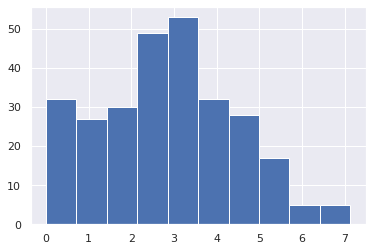

In [39]:
plt.hist(np.log(matriz_incidencia_train.sum()))

**Distribución de grado para alelos**

(array([1.4286e+04, 9.5400e+02, 1.3300e+02, 3.0000e+01, 0.0000e+00,
        1.2000e+01, 8.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

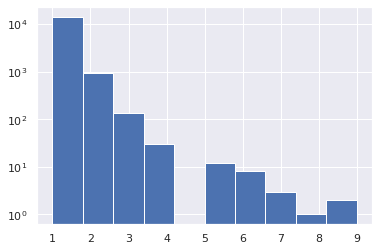

In [40]:
plt.hist(matriz_incidencia_train.sum(axis = 1), log=True)

¿VALE LA PENA ESTUDIAR ESTAS DISTRIBUCIONES?

### 4. Filtro Colaborativo Implícito

https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

En primer lugar, normalizamos con respecto a la cantidad de enlaces que tiene cada alelo. En las películas, esto se justifica como 

> *This is the idea of normalizing the user vectors so that a user with many ratings contributes less to any individual rating. This is to say that a like from a user who has only liked 10 items is more valuable to us than a like from someone who likes everything she comes across.*

In [42]:
#------------------------
# ITEM-ITEM CALCULATIONS
#------------------------

# As a first step we normalize the user vectors to unit vectors.

# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(matriz_incidencia_train).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_bipartita_normalizada = matriz_incidencia_train.divide(magnitude, axis='index')
data_bipartita_normalizada

,Adventurousness,Automobile speeding propensity,Extremely high intelligence,General cognitive ability,Intelligence (MTAG),Morning vs. evening chronotype,Adenocarcinoma,Adenocarcinoma in never smokers,BRCA1/2-negative high-risk breast cancer,Basal cell carcinoma,...,Parkinson's disease,Parkinson's disease or first degree relation to individual with Parkinson's disease,Polymyositis,Progressive supranuclear palsy,Recurrent major depressive disorder,Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 1 peripheral neuropathy),Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 2 peripheral neuropathy),Response to olanzapine in schizophrenia,Schizophrenia,Subjective response to lithium treatment
rs11589479-A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs6858066-A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs2071390-T,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs60843830-C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs8181326-A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs2414718-A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
rs61990820-A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
rs12493050-G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
rs12144699-A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Luego,calculamos la similaridad coseno para cada columna, obteniendo así qué fenotipos son parecidos.

In [43]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(data_bipartita_normalizada)
data_matrix.head()

,Adventurousness,Automobile speeding propensity,Extremely high intelligence,General cognitive ability,Intelligence (MTAG),Morning vs. evening chronotype,Adenocarcinoma,Adenocarcinoma in never smokers,BRCA1/2-negative high-risk breast cancer,Basal cell carcinoma,...,Parkinson's disease,Parkinson's disease or first degree relation to individual with Parkinson's disease,Polymyositis,Progressive supranuclear palsy,Recurrent major depressive disorder,Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 1 peripheral neuropathy),Response to anti-retroviral therapy (ddI/d4T) in HIV-1 infection (Grade 2 peripheral neuropathy),Response to olanzapine in schizophrenia,Schizophrenia,Subjective response to lithium treatment
Adventurousness,1.000000,0.0,0.000000,0.000000,0.001587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Automobile speeding propensity,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Extremely high intelligence,0.000000,0.0,1.000000,0.002083,0.037085,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
General cognitive ability,0.000000,0.0,0.002083,1.000000,0.044572,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001063,0.0
Intelligence (MTAG),0.001587,0.0,0.037085,0.044572,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002022,0.0,0.0,0.0,0.0,0.0,0.0,0.000884,0.0


Veamos similaridades

In [119]:
# print(data_matrix.loc['Drinking behavior'].nlargest(25))
print(data_matrix.loc['General cognitive ability'].nlargest(30))

General cognitive ability                                                                                                          1.000000
Intelligence (MTAG)                                                                                                                0.044572
Autism and major depressive disorder (MTAG)                                                                                        0.003859
Allergy                                                                                                                            0.002934
Bipolar disorder or body mass index                                                                                                0.002785
Extremely high intelligence                                                                                                        0.002083
Gastroesophageal reflux disease                                                                                                    0.001984
Cognitive ability, y

Construimos una nueva matriz, con los `n_neighbours` de cada fenotipo. Vendrían a ser los `n_neighbours` fenotipos más cercanos a cada fenotipos.

In [76]:
n_neighbours = 100
data_neighbours = pd.DataFrame(index=data_matrix.columns, columns=range(1,n_neighbours+1))
for i in range(0, len(data_matrix.columns)):
    data_neighbours.iloc[i,:n_neighbours] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:n_neighbours].index
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Adventurousness,Adventurousness,Intelligence (MTAG),Squamous cell lung carcinoma,Response to gemcitabine in pancreatic cancer,Serous borderline ovarian cancer,Serous invasive ovarian cancer,Small cell lung carcinoma,Sporadic neuroblastoma,Squamous cell carcinoma,Survival in pancreatic cancer,...,Breast cancer (progesterone-receptor positive),Breast cancer (estrogen-receptor positive),"Breast cancer (estrogen-receptor negative, pro...",Breast cancer (estrogen-receptor negative),Breast cancer,Bladder cancer,Basal cell carcinoma,BRCA1/2-negative high-risk breast cancer,Adenocarcinoma in never smokers,Adenocarcinoma
Automobile speeding propensity,Automobile speeding propensity,Type 2 diabetes,Subjective response to lithium treatment,Squamous cell lung carcinoma,Response to gemcitabine in pancreatic cancer,Serous borderline ovarian cancer,Serous invasive ovarian cancer,Small cell lung carcinoma,Sporadic neuroblastoma,Squamous cell carcinoma,...,Breast cancer (progesterone-receptor positive),Breast cancer (estrogen-receptor positive),"Breast cancer (estrogen-receptor negative, pro...",Breast cancer (estrogen-receptor negative),Breast cancer,Bladder cancer,Basal cell carcinoma,BRCA1/2-negative high-risk breast cancer,Adenocarcinoma in never smokers,Adenocarcinoma
Extremely high intelligence,Extremely high intelligence,Intelligence (MTAG),Autism and major depressive disorder (MTAG),General cognitive ability,Subjective response to lithium treatment,Survival in pancreatic cancer,Serous borderline ovarian cancer,Serous invasive ovarian cancer,Small cell lung carcinoma,Sporadic neuroblastoma,...,Cardia gastric cancer,Cancer,Breast cancer (progesterone-receptor positive),Breast cancer (estrogen-receptor positive),"Breast cancer (estrogen-receptor negative, pro...",Breast cancer (estrogen-receptor negative),Breast cancer,Bladder cancer,Basal cell carcinoma,BRCA1/2-negative high-risk breast cancer
General cognitive ability,General cognitive ability,Intelligence (MTAG),Autism and major depressive disorder (MTAG),Allergy,Bipolar disorder or body mass index,Extremely high intelligence,Gastroesophageal reflux disease,"Cognitive ability, years of educational attain...",Schizophrenia,Breast cancer,...,Colorectal cancer,Colorectal adenoma (advanced),Chronic lymphocytic leukemia or systemic lupus...,Non-glioblastoma glioma,Chronic lymphocytic leukemia,Cardia gastric cancer,Cancer,Breast cancer (progesterone-receptor positive),Breast cancer (estrogen-receptor positive),"Breast cancer (estrogen-receptor negative, pro..."
Intelligence (MTAG),Intelligence (MTAG),General cognitive ability,Extremely high intelligence,Autism and major depressive disorder (MTAG),Multiple system atrophy,Gastroesophageal reflux disease,Metabolic syndrome,Lung cancer,Parkinson's disease or first degree relation t...,Adventurousness,...,Colorectal cancer,Colorectal adenoma (advanced),Cirrhosis,Chronic lymphocytic leukemia or systemic lupus...,Chronic lymphocytic leukemia,Cardia gastric cancer,Cancer,Breast cancer (progesterone-receptor positive),Breast cancer (estrogen-receptor positive),"Breast cancer (estrogen-receptor negative, pro..."


Elegimos un alelo dentro del conjunto de entrenamiento

In [77]:
# np.random.seed(43)
alelo_prueba = np.random.choice(data_tripletes_train.alelo_riesgo.unique())
# alelo_prueba = 'rs6739779-C'
# alelo_prueba = 'rs4549631-C'
print(f'Alelo de prueba: {alelo_prueba}')


known_alelo_fenotipos = data_bipartita_normalizada.loc[alelo_prueba,:]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Fenotipos asociados al alelo: {known_alelo_fenotipos}')

Alelo de prueba: rs11231824-C
Fenotipos asociados al alelo: ['Systemic lupus erythematosus']


Dado esos fenotipos, seleccionamos los similares a partir de `data_neighbours`

In [78]:
# Construct the neighbourhood from the most similar items to the
# ones our alelo it's related
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
# most_similar_fenotipos
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
print(f'Fenotipos similares, sin rankear: {similar_list}')

Fenotipos similares, sin rankear: ['Cancer', 'Large artery stroke', 'Coronary heart disease', 'Diffuse cutaneous systemic sclerosis', 'Heart failure', 'Oral cavity cancer', 'Migraine with aura', 'Diffuse large B cell lymphoma', 'Giant cell arteritis', 'Systemic seropositive rheumatic diseases (Systemic sclerosis or systemic lupus erythematosus or rheumatoid arthritis or idiopathic inflammatory myopathies)', 'Colorectal adenoma (advanced)', 'Ulcerative colitis', 'Hypertension', 'Colorectal or endometrial cancer', 'Adenocarcinoma in never smokers', "Crohn's disease", 'Colorectal cancer', 'Endometrial endometrioid carcinoma', 'Lipoprotein phospholipase A2 activity in cardiovascular disease', 'Cutaneous squamous cell carcinoma', 'Carotid intima media thickness', 'Atrial fibrillation', 'Ovarian clear cell cancer', 'Hepatocellular carcinoma', 'Celiac disease', 'Renal cell carcinoma', 'Migraine - clinic-based', "Sjögren's syndrome", "Behcet's disease", 'Eosinophilic granulomatosis with polyan

Seleccionamos, dentro de la matriz de similaridades, los valores para los fenotipos similares

In [79]:
neighbourhood = data_matrix[similar_list].loc[similar_list]
neighbourhood.shape

(100, 100)

Creamos un vector que tiene los fenotipos similares, incluyendo los conocidos, y su *rating* (1 o 0).

In [80]:
# A user vector containing only the neighbourhood items and
# the known user likes.
fenotipos_probables = data_bipartita_normalizada.loc[alelo_prueba,:].loc[similar_list]
fenotipos_probables

Cancer                                       0.0
Large artery stroke                          0.0
Coronary heart disease                       0.0
Diffuse cutaneous systemic sclerosis         0.0
Heart failure                                0.0
                                            ... 
Systemic lupus erythematosus                 1.0
Uterine fibroids                             0.0
Intracranial aneurysm                        0.0
Oral cavity and pharyngeal cancer            0.0
Ovarian cancer in BRCA1 mutation carriers    0.0
Name: rs11231824-C, Length: 100, dtype: float64

Calculamos los scores y ordenamos.

In [81]:
# Calculate the score.
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
# score
score.sort_values(ascending = False, inplace = True)
# score

E imprimimos los fenotipos conocidos y el ranking

In [82]:
print(known_alelo_fenotipos)
print(score)

['Systemic lupus erythematosus']
Systemic lupus erythematosus                                                                                                                                   0.831770
Limited cutaneous systemic scleroderma                                                                                                                         0.026667
Chronic lymphocytic leukemia or systemic lupus erythematosus                                                                                                   0.014809
Systemic seropositive rheumatic diseases (Systemic sclerosis or systemic lupus erythematosus or rheumatoid arthritis or idiopathic inflammatory myopathies)    0.012724
Neuromyelitis optica (AQP4-IgG-positive)                                                                                                                       0.008790
                                                                                                                               

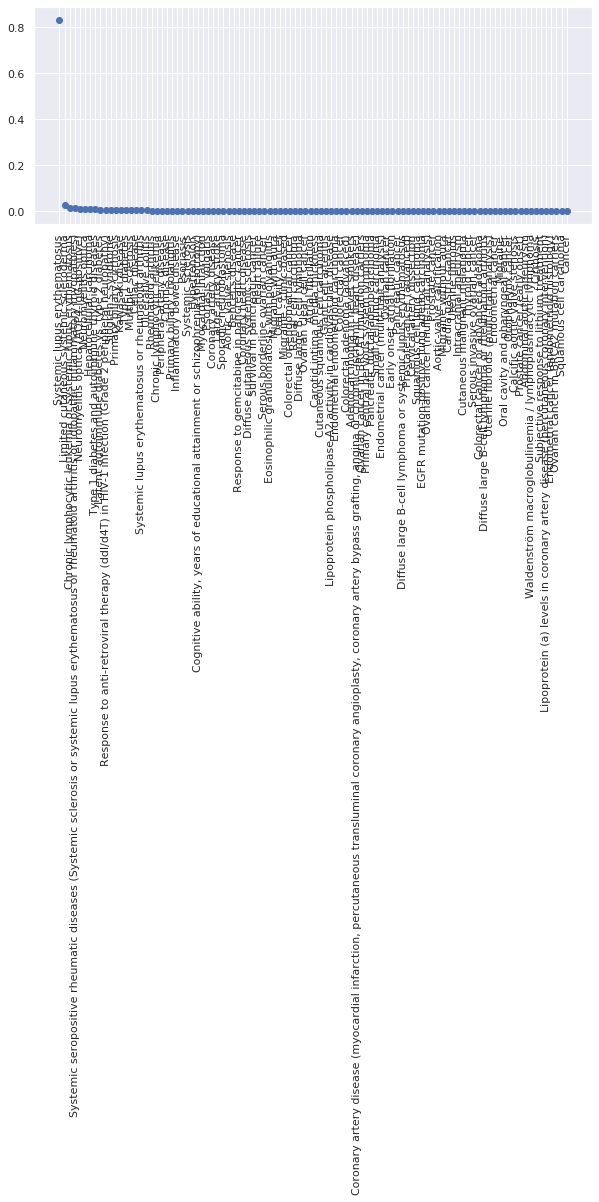

In [83]:
# sns.barplot(score.index, score.values)
plt.figure(figsize = (10,4))
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# def recomendaciones_alelo(alelo_index, data_bipartita_normalizada, data_neighbours, data_matrix):
#     known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_index]
#     known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values

#     most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]

#     similar_list = most_similar_fenotipos.values.tolist()
#     similar_list = list(set([item for sublist in similar_list for item in sublist]))

#     neighbourhood = data_matrix[similar_list].loc[similar_list]

#     fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]

#     score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
#     score.sort_values(ascending = False, inplace = True)

#     return score

In [ ]:
# score = recomendaciones_alelo(alelo_prueba_index, data_bipartita_normalizada, data_neighbours, data_matrix)

In [ ]:
# plt.scatter(score.index, score.values)
# plt.xticks(rotation = 90)

### Sobre Conjunto de Test

"A mano" por ahora

In [110]:
# np.random.seed(50)
alelo_prueba = np.random.choice(data_tripletes_test.alelo_riesgo)
print(f'Alelo a probar: {alelo_prueba}')

todos_fenotipos_asociados = data[data.alelo_riesgo == alelo_prueba].fenotipo.values
fenotipos_en_test = data_tripletes_test[data_tripletes_test.alelo_riesgo == alelo_prueba].fenotipo.values
# known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Todos fenotipos asociados al alelo: {todos_fenotipos_asociados}')
print(f'Fenotipos en Test: {fenotipos_en_test}')

fenotipos_en_train = data_bipartita_normalizada.loc[alelo_prueba]
fenotipos_en_train = fenotipos_en_train[fenotipos_en_train >0].index.values
print(f'Fenotipos en Train: {fenotipos_en_train}')

Alelo a probar: rs561722-G
Todos fenotipos asociados al alelo: ['Inflammatory bowel disease' 'Ulcerative colitis']
Fenotipos en Test: ['Inflammatory bowel disease']
Fenotipos en Train: ['Ulcerative colitis']


In [111]:
most_similar_fenotipos = data_neighbours.loc[fenotipos_en_test]
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
neighbourhood = data_matrix[similar_list].loc[similar_list]

In [112]:
fenotipos_probables = data_bipartita_normalizada.loc[alelo_prueba].loc[similar_list]
# fenotipos_probables

In [113]:
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
score.sort_values(ascending = False, inplace = True)
# print(f'Fenotipos en Train: {fenotipos_en_train}')
# print(f'Fenotipos en Test: {fenotipos_en_test}')
# print(score.nlargest(50))

In [114]:
mascara_colores = 2*score.nlargest(50).index.isin(fenotipos_en_train) + 1*score.nlargest(50).index.isin(fenotipos_en_test)
mascara_colores

array([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

<ipython-input-115-e49443476aa0>:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(score.nlargest(50).index, np.log(score.nlargest(50).values), c = mascara_colores, cmap = 'Set2')


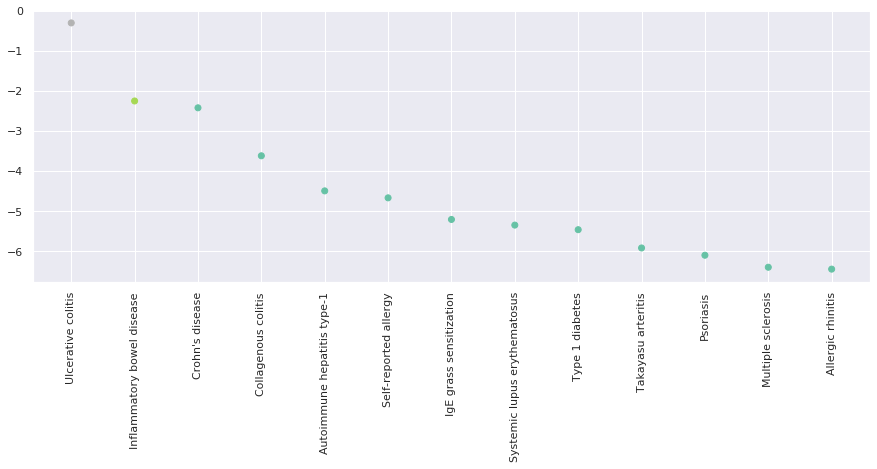

In [115]:
mascara_colores = 2*score.nlargest(50).index.isin(fenotipos_en_train) + 1*score.nlargest(50).index.isin(fenotipos_en_test)
plt.figure(figsize = (15,5))
plt.scatter(score.nlargest(50).index, np.log(score.nlargest(50).values), c = mascara_colores, cmap = 'Set2')
plt.xticks(rotation = 90)
plt.show()

1. grafico de fenotipos vs score
1. capacidad de priorizar dado 
1. Usar el paper de zhou


MARTES - 5 min
dimensión de los datos
encuadrar el problema biológico o metodológico



In [ ]:
def indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar):
    indices = []
    for fenotipo in fenotipos_a_evaluar:
        if fenotipo in fenotipos_recomendados:
            indices.append(fenotipos_recomendados.index(fenotipo))
        else:
            indices.append(-1)
    return indices

In [ ]:
n = 100
fenotipos_recomendados = list(score.index)
# fenotipos_recomendados = [x for x in fenotipos_recomendados if x not in fenotipos_train]



indices_aciertos(fenotipos_recomendados, todos_fenotipos_asociados)

In [ ]:
n = 10

resultados = []

for alelo_prueba_index in data_bipartita_test_1.index:
#     print(alelo_prueba_index)
    alelo_prueba = dict_id_to_alelo[alelo_prueba_index]
    known_alelo_fenotipos = data_bipartita_test_1.loc[alelo_prueba_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
#     print(f'Fenotipos asociados al alelo para generar recomendaciones: {known_alelo_fenotipos}')
    
    fenotipos_reportados_alelo = data_bipartita.loc[alelo_prueba_index]
    fenotipos_reportados_alelo = fenotipos_reportados_alelo[fenotipos_reportados_alelo >0].index.values
#     print(f'Todos fenotipos asociados al alelo: {fenotipos_reportados_alelo}')
    
    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = data_matrix[similar_list].loc[similar_list]
    
    fenotipos_probables = data_bipartita_test_1.loc[alelo_prueba_index].loc[similar_list]
    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)
#     print(score.nlargest(5))

    
    fenotipos_recomendados = list(score.index)
    fenotipos_usados_para_recomendar = known_alelo_fenotipos
    fenotipos_conocidos = fenotipos_reportados_alelo
    
    n_0 = len(fenotipos_usados_para_recomendar)
    fenotipos_recomendados = fenotipos_recomendados[n_0:n_0+n]
    fenotipos_a_evaluar = [x for x in fenotipos_conocidos if x not in fenotipos_usados_para_recomendar]
    
    idxs = indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar)
    
    resultados_alelo = dict(zip(fenotipos_a_evaluar, idxs))
    resultados_alelo['alelo'] = alelo_prueba
    resultados_alelo['indice_alelo'] = alelo_prueba_index
    resultados.append(resultados_alelo)
    
#     print(idxs)


In [ ]:
resultados_df = pd.DataFrame(resultados).set_index('indice_alelo')
resultados_df.head()

In [ ]:
indices = resultados_df.drop(columns = 'alelo').values
indices = indices[~np.isnan(indices)]
plt.hist(indices, bins = np.arange(-1.5,9.5))

In [ ]:
print(f'Porcentaje aciertos: {(indices>-1).sum()/indices.size}')
print(f'Porcentaje no aciertos: {(indices==-1).sum()/indices.size}')

### Cosas para hacer

1. Chequear sobre `categoria_fenotipo` que no sea trivial
1. Agregar segunda forma de evaluación: borrando '1' de la matriz de train
1. Chequear que al separar train y test no se rompa la red
1. Metodizar la evaluación para obtener una métrica
1. Chequear que no estemos cayendo en la parte "fácil" de la red --> ¿pregunta biológica?